<a href="https://colab.research.google.com/github/BKirill/MLatFIAN2020_homework/blob/main/MLatFIAN2020_seminar01_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get the Titanic dataset:

In [1]:
!wget https://github.com/HSE-LAMBDA/MLatFIAN2020/raw/master/seminar01/train.csv

--2020-10-05 17:22:23--  https://github.com/HSE-LAMBDA/MLatFIAN2020/raw/master/seminar01/train.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HSE-LAMBDA/MLatFIAN2020/master/seminar01/train.csv [following]
--2020-10-05 17:22:24--  https://raw.githubusercontent.com/HSE-LAMBDA/MLatFIAN2020/master/seminar01/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv.4’

train.csv.4         100%[===================>]  58.89K  --.-KB/s    in 0.007s  

2020-10-05 17:22:24 (7.86 MB/s) - ‘train.csv.4’ saved [60302/60302]



In [2]:
import pandas as pd
data = pd.read_csv("train.csv", index_col='PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### About the data
Here's some of the columns
* Name - a string with person's full name
* Survived - 1 if a person survived the shipwreck, 0 otherwise.
* Pclass - passenger class. Pclass == 3 is cheap'n'cheerful, Pclass == 1 is for moneybags.
* Sex - a person's gender
* Age - age in years, if available
* SibSp - number of siblings on a ship
* Parch - number of parents on a ship
* Fare - ticket cost
* Embarked - port where the passenger embarked
 * C = Cherbourg; Q = Queenstown; S = Southampton

## Task 1

In [3]:
# Compute survaval rate for each of the three passenger classes (`Pclass` = 1, 2 and 3)
# (can you do it using groupby?)

data.groupby("Pclass").Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

## Task 2

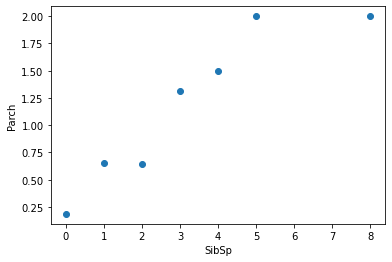

In [4]:
# Plot the average number of parents onboard (`Parch`) as a function of the 
# number of siblings onboard (`SibSp`)

import matplotlib.pyplot as plt

par_num = data.groupby("SibSp").Parch.mean()
plt.xlabel('SibSp')
plt.ylabel('Parch')
plt.scatter(par_num.index, par_num);

## Task 3

In [5]:
# Build a model with KNeighborsClassifier to get the accuracy of
# at least 0.75 on the validation part of the dataset

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler

def feature_selection_and_preprocessing(dataset):
  # Pre-processing the features
  features = dataset[["Fare", "Parch", "Sex", "SibSp", "Pclass", "Age"]].copy()
  features["AgeIsMissing"] = features.Age.isna().astype('int32')
  features["IsAChild"] = (features.Age < 18).astype('int32')
  avg_age = features.Age.mean()
  features.Age.fillna(avg_age, inplace=True)
  features["Sex"] = (features.Sex == 'male').astype('int32')

  # Selecting the features
  features = features[["SibSp", "Parch", "IsAChild", 
                       "Pclass", "Sex", "AgeIsMissing"]]

  # Scaling the features
  scaler = RobustScaler()
  scaler.fit_transform(features)

  return features

model = KNeighborsClassifier(
    n_neighbors=13
)


# Validation code (do not touch)
data = pd.read_csv("train.csv", index_col='PassengerId')
data_train = data.iloc[:-100]
data_test = data.iloc[-100:]

model.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)

test_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_test.drop('Survived', axis=1)
    )
)
print("Test accuracy:", accuracy_score(
    data_test['Survived'],
    test_predictions
))

Test accuracy: 0.86


## Task 4

Check how your model from the previous task performs on randomized splits to train / test (with test set of size 100). Plot the histogram of the test error distribution.

*Hint: check sklearn's `sklearn.model_selection.train_test_split` function.*

100%|██████████| 2000/2000 [00:35<00:00, 55.95it/s]


Mean accuracy:  0.8043800000000001


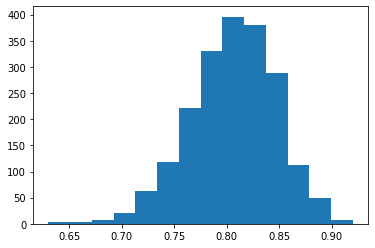

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import trange

data = pd.read_csv("train.csv", index_col='PassengerId')
acc_scores = []

for _ in trange(2000):
  # Randomly splitting the data
  data_train, data_test = train_test_split(data, test_size=100)

  # Training the model
  model.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
  )

  # Evaluating the model
  test_predictions = model.predict(
      feature_selection_and_preprocessing(
          data_test.drop('Survived', axis=1)
      )
  )
  acc_scores.append(accuracy_score(
      data_test['Survived'],
      test_predictions
  ))

# Plotting the results
print('Mean accuracy: ', np.mean(acc_scores))
bins = np.linspace(np.min(acc_scores), np.max(acc_scores), 15)
plt.hist(acc_scores, bins);
plt.show()